In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('D:/Users/tiniojan/ExperimentsPhD/June_19_24/wasslsp')

from src.utils import *
from src.kernels import Kernel

init_notebook_mode(connected=True) ## plotly init

import os
path_data = 'D:/Users/tiniojan/ExperimentsPhD/June_19_24/wasslsp/data/'



In [5]:
df_hr = pd.read_csv(path_data + 'HRVProcessedData[[Beat]].csv')

In [7]:
df_hr.head(), df_hr.columns, df_hr.shape

(   Unnamed: 0   Time        niHR        RR
 0           1  0.000  182.926773  328.0001
 1           2  0.328  182.926773  328.0001
 2           3  0.716  154.639375  387.9995
 3           4  1.124  147.058679  408.0004
 4           5  1.500  159.574468  376.0000,
 Index(['Unnamed: 0', 'Time', 'niHR', 'RR'], dtype='object'),
 (17178, 4))

In [9]:
df_hr['niHR_scaled'] = np.log(df_hr[['niHR']])

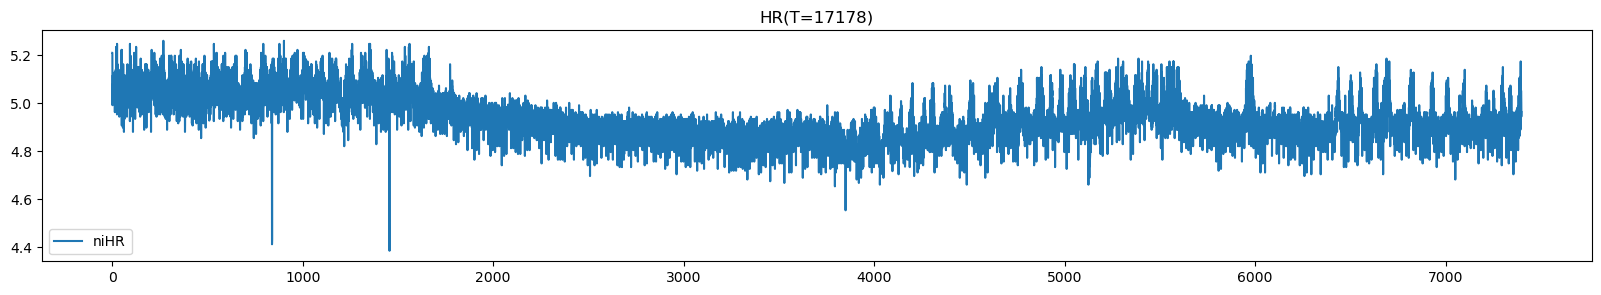

In [11]:
plt.rcParams["figure.figsize"] = (20,3)
#plt.plot(df_hr['Time'], df_hr['niHR'], label="niHR")
plt.plot(df_hr['Time'], df_hr['niHR_scaled'], label="niHR")
plt.legend()
plt.title("HR(T=17178)")
plt.show()

# NW Conditional CDF

In [41]:

T = df_hr.shape[0]
n_replications = 3
d = 1


X_tvar_2 = np.zeros(T)
X_tvar_2_mean = np.zeros(T)

X_tvar_2_replications = np.zeros((n_replications, T))

X_dict = {}

for replication in range(n_replications):
    sigma_star = lambda u: 0.01
    t = 1
    epsilon = np.random.normal(size=(T))
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvar_2[t] = df_hr['niHR_scaled'].values[t] + sigma_star(t/T) * epsilon[t]
        X[t] = [X_tvar_2[t-1]]
        t += 1
        
    X_dict[str(replication)] = X
    X_tvar_2_replications[replication] = X_tvar_2

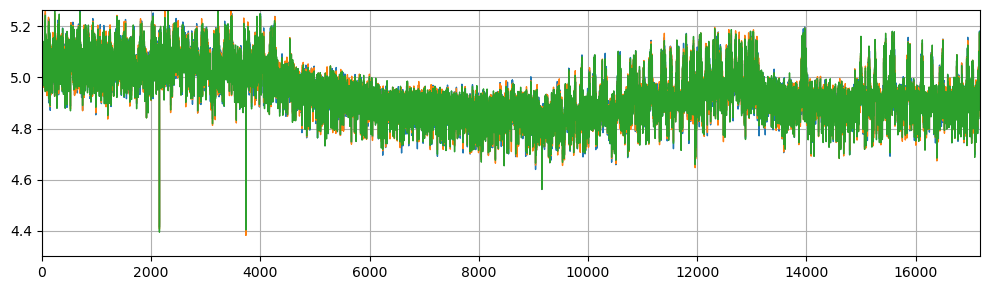

In [43]:
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=1)
    plt.ylim(4.3, max(X_tvar_2_replications[replication]))
    plt.xlim(0, T)
    plt.tight_layout()
    plt.grid(True)
plt.show()

In [99]:
times_t = [4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500] 
times_T = [T]
times_sigma = [10**-1, 10**-2, 10**-3, 10**-4, 10**-5]
n_replications = 5
d = 1


In [101]:
X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

for sigma_ in times_sigma:
    X_tvar_2_replications[f"sigma:{sigma_}"] = np.zeros((n_replications, T))
    X_dict[f"sigma:{sigma_}"] = {}

In [103]:
import torch
import scipy as scp
import matplotlib
from matplotlib import cm
from scipy.stats import wasserstein_distance

In [105]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for sigma_ in times_sigma:
        for replication in range(n_replications):
            sigma_star = lambda u: sigma_
            t = 1
            epsilon = np.random.normal(0, sigma_, size=(T))
            X = np.zeros((T,d))
            X_tvar_2_T = np.zeros(T)
            while t <= T-1 :
                X_tvar_2_T[t] = df_hr['niHR_scaled'].values[t] + sigma_star(t/T) * epsilon[t]
            
                X[t] = [X_tvar_2_T[t-1]]
                t += 1

            X_tvar_2_replications[f"sigma:{sigma_}"][replication] = X_tvar_2_T
            X_dict[f"sigma:{sigma_}"][str(replication)] = X


In [107]:
X_tvar_2 = {}

for t in times_t:
    for sigma_ in times_sigma:
        X_tvar_2[f"t:{t}_sigma:{sigma_}"] = {}

# X_tvar_2

In [109]:
for t in times_t:
    for sigma_ in times_sigma:
        X_tvar_2[f"t:{t}_sigma:{sigma_}"] = []


for t in times_t:
    for replication in range(n_replications):
        for sigma_ in times_sigma:
            z = X_tvar_2_replications[f"sigma:{sigma_}"][replication][t-1]
            X_tvar_2[f"t:{t}_sigma:{sigma_}"].append(z)

for t in times_t:
    for sigma_ in times_sigma:
        X_tvar_2[f"t:{t}_sigma:{sigma_}"] = np.array(X_tvar_2[f"t:{t}_sigma:{sigma_}"])

In [111]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvar_2 = {}
for t in times_t:
    for sigma_ in times_sigma:
        norm_X_tvar_2[f"t:{t}_sigma:{sigma_}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}"])
        

# space_kernel = "gaussian"; time_kernel = "uniform"

In [113]:
space_kernel = "gaussian" #"silverman"
time_kernel = "uniform" #"tricube"
xi = 0.4 / (2*(d+1))
lambda_ = 1/12

T = df_hr.shape[0]
gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for sigma_ in times_sigma:
        gaussian_weights[f"t:{t}_sigma:{sigma_}"] = {}
    
for sigma_ in times_sigma:
    bandwidth = lambda_ * (T **(-xi))
    gaussian_kernel[f"sigma:{sigma_}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [115]:
gaussian_kernel

{'sigma:0.1': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:0.01': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:0.001': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:0.0001': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:1e-05': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform')}

In [117]:
for replication in range(n_replications):
    for t in times_t:
        for sigma_ in times_sigma:
            gaussian_weights[f"t:{t}_sigma:{sigma_}"][str(replication)] = \
            gaussian_kernel[f"sigma:{sigma_}"].fit(X_dict[f"sigma:{sigma_}"][str(replication)], t)

In [118]:
n_replications

5

In [119]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )


for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}"] = {}


for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}"][str(replication)]

In [120]:
empirical_cds = {}
for t in times_t:
    for sigma_ in times_sigma:
        empirical_cds[f"t:{t}_sigma:{sigma_}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}"])


In [121]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [122]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for sigma_ in times_sigma:
        x_rep[f"t:{t}_sigma:{sigma_}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_sigma:{sigma_}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_sigma:{sigma_}"] = {}

for replication in range(n_replications): 
    for t in times_t:
        for sigma_ in times_sigma:
            y, x = eval_univariate(
                X_tvar_2_replications[f"sigma:{sigma_}"][replication], gaussian_weights_tensor[f"t:{t}_sigma:{sigma_}"][str(replication)]
            )
            x_rep[f"t:{t}_sigma:{sigma_}"][replication] = x
            y_rep[f"t:{t}_sigma:{sigma_}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"sigma:{sigma_}"][replication]))
            wasserstein_distances[f"t:{t}_sigma:{sigma_}"][str(replication)] = distance
   
   
            #plt.rcParams["figure.figsize"] = (6,4)
            #plt.plot(x, y, label=f"t:{t}")# _replication:{replication}")
            #plt.xlabel(r'$y$')
            #plt.ylabel(r'$\hat{F}_t(y|x)$')
            #plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
            #plt.legend()

In [123]:
wass_distances_all_replications = {}

for t in times_t:
    for sigma_ in times_sigma:
        wass_distances_all_replications[f"t:{t}_sigma:{sigma_}"] = []

for t in times_t:
    for sigma_ in times_sigma:       
        for replication in range(n_replications):
            wass_distances_all_replications[f"t:{t}_sigma:{sigma_}"].append(wasserstein_distances[f"t:{t}_sigma:{sigma_}"][str(replication)])
        

In [124]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for sigma_ in times_sigma:
        wass_distances_empirical_meanNW[f"t:{t}_sigma:{sigma_}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_sigma:{sigma_}"], y_rep[f"t:{t}_sigma:{sigma_}"].mean(axis=0)
        )

In [125]:
wass_distances_empirical_meanNW

{'t:4000_sigma:0.1': 0.811070008399663,
 't:4000_sigma:0.01': 0.8120145264064835,
 't:4000_sigma:0.001': 0.8122144150330644,
 't:4000_sigma:0.0001': 0.8121943010379808,
 't:4000_sigma:1e-05': 0.8123645718877401,
 't:4500_sigma:0.1': 0.6261313534519078,
 't:4500_sigma:0.01': 0.6318803659881991,
 't:4500_sigma:0.001': 0.6326028838410616,
 't:4500_sigma:0.0001': 0.6318634697271254,
 't:4500_sigma:1e-05': 0.6325263102184743,
 't:5000_sigma:0.1': 0.5309433903145522,
 't:5000_sigma:0.01': 0.5321448652176548,
 't:5000_sigma:0.001': 0.5323111937920015,
 't:5000_sigma:0.0001': 0.5323550648656502,
 't:5000_sigma:1e-05': 0.5325360435074052,
 't:5500_sigma:0.1': 0.4626212375901139,
 't:5500_sigma:0.01': 0.46192134689063324,
 't:5500_sigma:0.001': 0.46237194318296426,
 't:5500_sigma:0.0001': 0.4620752544475041,
 't:5500_sigma:1e-05': 0.4621903701858896,
 't:6000_sigma:0.1': 0.3325657937143859,
 't:6000_sigma:0.01': 0.3274911113831589,
 't:6000_sigma:0.001': 0.32760088228324974,
 't:6000_sigma:0.000

In [126]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for sigma_ in times_sigma:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_sigma:{sigma_}"])

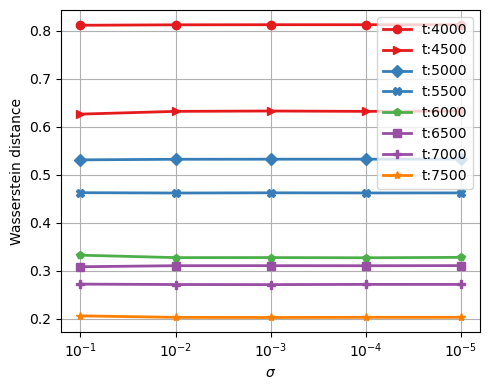

In [127]:

plt.rcParams["figure.figsize"] = (5,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
#markers = ['o', '>', 'D', 'X', "p"]
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 

times_sigma_cat = [r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$10^{-5}$']

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_sigma_cat, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    #plt.ylim(0.18, 0.4)
    plt.xlabel(r'$\sigma$')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)